In [8]:
#librerias
import pandas as pd
import numpy as np
import pyodbc

import matplotlib.pyplot as plt
import seaborn as sns


from datetime import datetime
from dateutil.relativedelta import relativedelta

import warnings
warnings.filterwarnings('ignore')


**1. Selección de datos**

In [9]:
#Conexión database
conn = pyodbc.connect(DRIVER='{ODBC Driver 17 for SQL Server}',
                      SERVER='dblatinkadwh.database.windows.net',
                      DATABASE='DWH_LaTinka',
                      UID='sandra.sanchez',
                      PWD='Latinka01*')
print(conn)


In [10]:
#No se tomó en cuenta los datos con target null
q0 = """SELECT *
        FROM [EDS].[TABLON_MODELO_FUGA_CLIENTE]
        WHERE CODMES=202212"""
df = pd.read_sql_query(q0,conn)

#Cerrar conexión 
conn.close()

In [11]:
df

,CODMES,ID_CLIENTE,VENTA_NETA_CASINO,VENTA_NETA_DEPORTE_VIRTUAL,VENTA_NETA_GANA_DIARIO,VENTA_NETA_GANAGOL,VENTA_NETA_KABALA,VENTA_NETA_KINELO,VENTA_NETA_RASPAYA,VENTA_NETA_TE_APUESTO,...,FECHA_ALTA_SISTEMA,FECHA_NACIMIENTO,PRODUCTO_PRINCIPAL,ESTADO_CLIENTE,FRECUENCY,MONETARY,RECENCY,FECHA_PRIMERA_ACCION,FECHA_ULTIMA_ACCION,FLG_FELICIDAD
0,202212,19433,0.0,0.0,30.0,0.0,5.0,0.0,0.0,0.0,...,2010-07-13,1964-11-10,Gana Diario,4. No Activo,3. Frecuente,5. Muy Bajo,4. Perdido,2021-08-12,2022-12-25,None
1,202212,804013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,...,2019-04-27,1985-07-08,Te Apuesto,2. Recurrente,4. Habitual,5. Muy Bajo,1. Activo,2019-06-14,2023-04-15,No Feliz
2,202212,1562627,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,...,2022-01-10,1982-06-19,Gana Diario,4. No Activo,5. Ocasional,5. Muy Bajo,3. Dormido 2,2022-06-25,2023-01-29,None
3,202212,1676749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,2022-04-21,2002-01-07,Te Apuesto,4. No Activo,5. Ocasional,5. Muy Bajo,4. Perdido,2022-05-09,2022-12-18,None
4,202212,711607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.0,...,2019-01-03,1989-04-22,Te Apuesto,3. Esporadico,5. Ocasional,5. Muy Bajo,4. Perdido,2019-07-02,2022-12-18,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141566,202212,660588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,...,2018-06-14,1987-06-26,Te Apuesto,3. Esporadico,5. Ocasional,5. Muy Bajo,4. Perdido,2022-12-02,2022-12-02,None
141567,202212,1693038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2022-05-04,1993-04-07,Tinka,2. Recurrente,4. Habitual,5. Muy Bajo,1. Activo,2022-05-18,2023-04-16,None
141568,202212,2116975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,487.0,...,2022-12-03,1985-12-19,Te Apuesto,2. Recurrente,2. Intensivo,5. Muy Bajo,1. Activo,2022-12-04,2023-04-16,Feliz
141569,202212,1022154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2645.0,...,2020-04-02,1993-02-27,Te Apuesto,4. No Activo,3. Frecuente,3. Medio,3. Dormido 2,2020-04-02,2023-01-01,Feliz


**2. Procesamiento**

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141571 entries, 0 to 141570
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   CODMES                      141571 non-null  int64  
 1   ID_CLIENTE                  141571 non-null  int64  
 2   VENTA_NETA_CASINO           141571 non-null  float64
 3   VENTA_NETA_DEPORTE_VIRTUAL  141571 non-null  float64
 4   VENTA_NETA_GANA_DIARIO      141571 non-null  float64
 5   VENTA_NETA_GANAGOL          141571 non-null  float64
 6   VENTA_NETA_KABALA           141571 non-null  float64
 7   VENTA_NETA_KINELO           141571 non-null  float64
 8   VENTA_NETA_RASPAYA          141571 non-null  float64
 9   VENTA_NETA_TE_APUESTO       141571 non-null  float64
 10  VENTA_NETA_TINKA            141571 non-null  float64
 11  NUM_VISITA                  141571 non-null  int64  
 12  TOTAL_RECARGA               141571 non-null  float64
 13  TOTAL_TRANSACC

In [13]:
#Conversion de String a datetime
df['FECHA_ALTA_SISTEMA'] = pd.to_datetime(df['FECHA_ALTA_SISTEMA'], format = "%Y-%m-%d")
df['FECHA_NACIMIENTO'] = pd.to_datetime(df['FECHA_NACIMIENTO'], format = "%Y-%m-%d")
df['FECHA_PRIMERA_ACCION'] = pd.to_datetime(df['FECHA_PRIMERA_ACCION'], format="%Y-%m-%d")
df['FECHA_ULTIMA_ACCION'] = pd.to_datetime(df['FECHA_ULTIMA_ACCION'], format = "%Y-%m-%d")

In [16]:
df.isnull().sum()

CODMES                         0
ID_CLIENTE                     0
VENTA_NETA_CASINO              0
VENTA_NETA_DEPORTE_VIRTUAL     0
VENTA_NETA_GANA_DIARIO         0
VENTA_NETA_GANAGOL             0
VENTA_NETA_KABALA              0
VENTA_NETA_KINELO              0
VENTA_NETA_RASPAYA             0
VENTA_NETA_TE_APUESTO          0
VENTA_NETA_TINKA               0
NUM_VISITA                     0
TOTAL_RECARGA                  0
TOTAL_TRANSACCION_RECARGA      0
FECHA_ALTA_SISTEMA             0
FECHA_NACIMIENTO              44
PRODUCTO_PRINCIPAL             0
ESTADO_CLIENTE                 0
FRECUENCY                      0
MONETARY                       0
RECENCY                        0
FECHA_PRIMERA_ACCION           0
FECHA_ULTIMA_ACCION            0
FLG_FELICIDAD                  0
dtype: int64

In [15]:
df['FLG_FELICIDAD'] = df['FLG_FELICIDAD'].fillna(2)

In [17]:
#Eliminar filas con valores nulos 
df.dropna(inplace=True)

In [18]:
#Calular la Edad
df['EDAD'] = ((datetime.now() -df['FECHA_NACIMIENTO']).dt.days / 365).round(0).astype("int64")

In [19]:
df['DIAS_CON'] = (df['FECHA_ULTIMA_ACCION']-df['FECHA_PRIMERA_ACCION']).dt.days


In [20]:
#Reclass variables
df['PRODUCTO_PRINCIPAL'] = np.where(df['PRODUCTO_PRINCIPAL'] == 'Tinka', 1, 
                                            np.where(df['PRODUCTO_PRINCIPAL'] == 'Kabala', 2,
                                            np.where(df['PRODUCTO_PRINCIPAL'] == 'Te Apuesto', 3,
                                            np.where(df['PRODUCTO_PRINCIPAL'] == 'Casino', 4,
                                            np.where(df['PRODUCTO_PRINCIPAL'] == 'Gana Diario', 5,
                                            np.where(df['PRODUCTO_PRINCIPAL'] == 'Raspaya', 6,
                                            np.where(df['PRODUCTO_PRINCIPAL'] == 'Kinelo', 7,
                                            np.where(df['PRODUCTO_PRINCIPAL'] == 'Ganagol', 8,9))))))))

df['ESTADO_CLIENTE'] = np.where(df['ESTADO_CLIENTE'] == '4. No Activo',4,
                                        np.where(df['ESTADO_CLIENTE'] == '2. Recurrente',2,
                                        np.where(df['ESTADO_CLIENTE'] == '3. Esporadico',3,1)))

df['FRECUENCY'] = np.where(df['FRECUENCY'] == '1. Permanente',1,
                                   np.where(df['FRECUENCY'] == '1. Permanente',1,
                                   np.where(df['FRECUENCY'] == '2. Intensivo',2,
                                   np.where(df['FRECUENCY'] == '3. Frecuente',3,
                                   np.where(df['FRECUENCY'] == '4. Habitual',4,5)))))

df['MONETARY'] = np.where(df['MONETARY'] == '1. Muy Alto',1,
                          np.where(df['MONETARY'] == '2. Alto', 2,
                          np.where(df['MONETARY'] == '3. Medio', 3,
                          np.where(df['MONETARY'] == '4. Bajo', 4,5))))

df['RECENCY'] = np.where(df['RECENCY'] == '4. Perdido',1,0)

df['FLG_FELICIDAD'] = np.where(df['FLG_FELICIDAD'] == 'No Feliz',0,np.where(df['FLG_FELICIDAD'] == 2,2,1))

In [21]:
df.set_index('ID_CLIENTE',inplace=True)

In [22]:
df.head()

,CODMES,VENTA_NETA_CASINO,VENTA_NETA_DEPORTE_VIRTUAL,VENTA_NETA_GANA_DIARIO,VENTA_NETA_GANAGOL,VENTA_NETA_KABALA,VENTA_NETA_KINELO,VENTA_NETA_RASPAYA,VENTA_NETA_TE_APUESTO,VENTA_NETA_TINKA,...,PRODUCTO_PRINCIPAL,ESTADO_CLIENTE,FRECUENCY,MONETARY,RECENCY,FECHA_PRIMERA_ACCION,FECHA_ULTIMA_ACCION,FLG_FELICIDAD,EDAD,DIAS_CON
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
19433,202212,0.0,0.0,30.0,0.0,5.0,0.0,0.0,0.0,0.0,...,5,4,3,5,1,2021-08-12,2022-12-25,2,59,500
804013,202212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,...,3,2,4,5,0,2019-06-14,2023-04-15,0,38,1401
1562627,202212,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,5.0,...,5,4,5,5,0,2022-06-25,2023-01-29,2,41,218
1676749,202212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,...,3,4,5,5,1,2022-05-09,2022-12-18,2,21,223
711607,202212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.0,0.0,...,3,3,5,5,1,2019-07-02,2022-12-18,2,34,1265


In [23]:
df2 = df.loc[:,['TOTAL_RECARGA', 'TOTAL_TRANSACCION_RECARGA','PRODUCTO_PRINCIPAL', 'FRECUENCY', 'MONETARY', 'RECENCY', 'EDAD', 'DIAS_CON', 'FLG_FELICIDAD']]

In [24]:
df2.groupby('RECENCY')['RECENCY'].count()

RECENCY
0    90688
1    50839
Name: RECENCY, dtype: int64

## División en objetivo y variables

In [25]:
X = df2.drop(['RECENCY'], axis=1)
Y = df2['RECENCY']

In [26]:
X.head(3)

,TOTAL_RECARGA,TOTAL_TRANSACCION_RECARGA,PRODUCTO_PRINCIPAL,FRECUENCY,MONETARY,EDAD,DIAS_CON,FLG_FELICIDAD
ID_CLIENTE,,,,,,,,
19433,30.0,1,5,3,5,59,500,2
804013,20.0,1,3,4,5,38,1401,0
1562627,15.0,1,5,5,5,41,218,2


In [27]:
Y.unique()

array([1, 0])

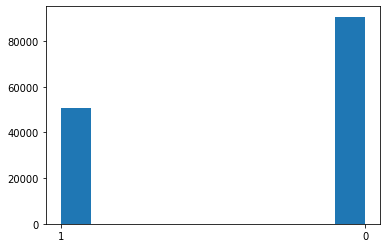

In [28]:
plt.hist(df2['RECENCY'].astype('str'))
plt.show()

## Usando UBML

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test , Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=29)
print(len(X_train))
print(len(X_test))

113221
28306


In [30]:
from ubml.train_test import classification_train_test
metrics_performance, best_model = classification_train_test(x_train=X_train, x_test=X_test, y_train=Y_train, y_test=Y_test)
print(best_model)
metrics_performance


Random Forest Classifier


,accuracy score train,accuracy score test,f1 score train,f1 score test,recall score train,recall score test,jaccard score train,jaccard score test,precision score train,precision score test
Logistic Regression,0.743,0.740,0.636,0.633,0.626,0.621,0.466,0.463,0.646,0.645
KNN Classifier,0.873,0.824,0.810,0.738,0.754,0.688,0.681,0.585,0.876,0.797
SVM Classifier,0.758,0.751,0.661,0.653,0.656,0.649,0.494,0.485,0.665,0.657
Naive Bayes Classifier,0.572,0.567,0.612,0.610,0.941,0.940,0.441,0.439,0.453,0.452
Decision Tree Classifier,0.998,0.803,0.997,0.729,0.996,0.732,0.994,0.573,0.999,0.726
Random Forest Classifier,0.998,0.844,0.997,0.765,0.998,0.707,0.994,0.620,0.996,0.835


In [31]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, Y_train)


LogisticRegression()

In [32]:
## Exportar el modelo 
import joblib
joblib.dump(lr,"tinka_model_lr.pkl")

['tinka_model_lr.pkl']

In [33]:
Y_predic = lr.predict(X_test)
print(Y_predic)


[0 0 0 ... 0 0 0]


In [34]:
prob_test_data = lr.predict_proba(X_test)
print(prob_test_data)

[[7.08948773e-01 2.91051227e-01]
 [8.75381768e-01 1.24618232e-01]
 [8.87813735e-01 1.12186265e-01]
 ...
 [6.09987957e-01 3.90012043e-01]
 [7.54175834e-01 2.45824166e-01]
 [9.99369610e-01 6.30390118e-04]]


In [35]:
len(X_test)


28306

In [36]:
len(Y_predic)


28306

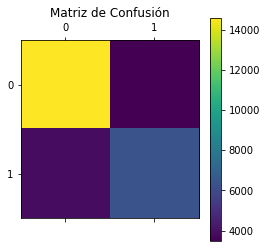

In [37]:
#Matriz de confusion 
from sklearn.metrics import confusion_matrix
import pylab as pl
cm = confusion_matrix(Y_test, Y_predic)
pl.matshow(cm)
pl.title('Matriz de Confusión')
pl.colorbar()
pl.show()


In [38]:
cm

array([[14599,  3489],
       [ 3874,  6344]], dtype=int64)

In [39]:

from sklearn.metrics import confusion_matrix
# y_pred = clf.predict(X_test)
cm = confusion_matrix(Y_test, Y_predic)
print(cm)


[[14599  3489]
 [ 3874  6344]]


In [40]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_predic))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80     18088
           1       0.65      0.62      0.63     10218

    accuracy                           0.74     28306
   macro avg       0.72      0.71      0.72     28306
weighted avg       0.74      0.74      0.74     28306



# 3. Predicción

In [41]:
#Importar el modelo 
import joblib
model = joblib.load("tinka_model_lr.pkl")

In [42]:
#Conexión database
conn1 = pyodbc.connect(DRIVER='{ODBC Driver 17 for SQL Server}',
                      SERVER='dblatinkadwh.database.windows.net',
                      DATABASE='DWH_LaTinka',
                      UID='sandra.sanchez',
                      PWD='Latinka01*')

In [43]:
# No se tomó en cuenta los datos con target null
q1 = """SELECT *
        FROM EDS.TABLON_VARIABLE_FUGA """
df2 = pd.read_sql_query(q1, conn1)

#Cerrar conexión
conn1.close()


In [44]:
df2

,CODMES,ID_CLIENTE,TOTAL_RECARGA,TOTAL_TRANSACCION,FECHA_PRIMERA_RECARGA,FECHA_ULTIMA_RECARGA,PRODUCTO_PRINCIPAL,FRECUENCY,RECENCY,MONETARY,FECHA_NACIMIENTO,INDICE_FELICIDAD
0,202301,1870460.0,20.00,1.00,2022-11-30,2022-11-30,Te Apuesto,5. Ocasional,4. Perdido,5. Muy Bajo,1997-03-25,0.0
1,202301,2031003.0,64.00,3.00,2022-11-19,2022-11-24,Te Apuesto,3. Frecuente,4. Perdido,5. Muy Bajo,1990-05-25,0.0
2,202301,1861970.0,45.00,2.00,2022-08-16,2022-12-03,Te Apuesto,4. Habitual,3. Dormido 2,5. Muy Bajo,1995-06-17,1.0
3,202301,839610.0,18.67,1.00,2022-07-07,2023-01-11,Tinka,5. Ocasional,2. Dormido 1,5. Muy Bajo,1986-12-24,0.0
4,202301,2153536.0,44.00,1.00,2022-12-13,2022-12-13,Te Apuesto,4. Habitual,3. Dormido 2,5. Muy Bajo,2001-07-01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4967605,202301,1931339.0,90.00,3.00,2022-10-03,2022-10-12,Te Apuesto,3. Frecuente,4. Perdido,5. Muy Bajo,1998-06-15,0.0
4967606,202301,1921475.0,25.00,1.00,2022-09-26,2022-10-04,Tinka,5. Ocasional,4. Perdido,5. Muy Bajo,1991-11-23,0.0
4967607,202301,1908965.0,298.00,9.40,2022-09-24,2023-01-15,Te Apuesto,2. Intensivo,2. Dormido 1,4. Bajo,1977-01-09,0.0
4967608,202301,967744.0,30.00,1.00,2022-04-10,2022-04-10,Gana Diario,3. Frecuente,4. Perdido,5. Muy Bajo,1982-03-17,0.0


In [45]:
df2 = df2.rename(columns={'TOTAL_TRANSACCION':'TOTAL_TRANSACCION_RECARGA','FECHA_PRIMERA_RECARGA':'FECHA_PRIMERA_ACCION','FECHA_ULTIMA_RECARGA':'FECHA_ULTIMA_ACCION','INDICE_FELICIDAD':'FLG_FELICIDAD'})

In [46]:
#Conversion de String a datetime
#df2['FECHA_ALTA_SISTEMA'] = pd.to_datetime(df2['FECHA_ALTA_SISTEMA'], format = "%Y-%m-%d")
df2['FECHA_NACIMIENTO'] = pd.to_datetime(df2['FECHA_NACIMIENTO'], format = "%Y-%m-%d",errors='coerce')
df2['FECHA_PRIMERA_ACCION'] = pd.to_datetime(df2['FECHA_PRIMERA_ACCION'], format="%Y-%m-%d",errors='coerce')
df2['FECHA_ULTIMA_ACCION'] = pd.to_datetime(df2['FECHA_ULTIMA_ACCION'], format = "%Y-%m-%d",errors='coerce')

In [47]:
df['FLG_FELICIDAD'] = df['FLG_FELICIDAD'].fillna(2)

In [48]:
# Eliminar filas con valores nulos
df2.dropna(inplace=True)


# Calular la Edad
df2['EDAD'] = ((datetime.now() - df2['FECHA_NACIMIENTO']
               ).dt.days / 365).round(0).astype("int64")

df2['DIAS_CON'] = (df2['FECHA_ULTIMA_ACCION']-df2['FECHA_PRIMERA_ACCION']).dt.days


In [49]:

# Reclass variables
df2['PRODUCTO_PRINCIPAL'] = np.where(df2['PRODUCTO_PRINCIPAL'] == 'Tinka', 1,
                                    np.where(df2['PRODUCTO_PRINCIPAL'] == 'Kabala', 2,
                                             np.where(df2['PRODUCTO_PRINCIPAL'] == 'Te Apuesto', 3,
                                                      np.where(df2['PRODUCTO_PRINCIPAL'] == 'Casino', 4,
                                                               np.where(df2['PRODUCTO_PRINCIPAL'] == 'Gana Diario', 5,
                                                                        np.where(df2['PRODUCTO_PRINCIPAL'] == 'Raspaya', 6,
                                                                                 np.where(df2['PRODUCTO_PRINCIPAL'] == 'Kinelo', 7,
                                                                                          np.where(df2['PRODUCTO_PRINCIPAL'] == 'Ganagol', 8, 9))))))))

#df2['ESTADO_CLIENTE'] = np.where(df2['ESTADO_CLIENTE'] == '4. No Activo', 4,
#                                np.where(df2['ESTADO_CLIENTE'] == '2. Recurrente', 2,
#                                         np.where(df2['ESTADO_CLIENTE'] == '3. Esporadico', 3, 1)))

df2['FRECUENCY'] = np.where(df2['FRECUENCY'] == '1. Permanente', 1,
                           np.where(df2['FRECUENCY'] == '1. Permanente', 1,
                                    np.where(df2['FRECUENCY'] == '2. Intensivo', 2,
                                             np.where(df2['FRECUENCY'] == '3. Frecuente', 3,
                                                      np.where(df2['FRECUENCY'] == '4. Habitual', 4, 5)))))

df2['MONETARY'] = np.where(df2['MONETARY'] == '1. Muy Alto', 1,
                          np.where(df2['MONETARY'] == '2. Alto', 2,
                          np.where(df2['MONETARY'] == '3. Medio', 3,
                                   np.where(df2['MONETARY'] == '4. Bajo', 4, 5))))

df2['RECENCY'] = np.where(df2['RECENCY'] == '1. Activo', 1,
                         np.where(df2['RECENCY'] == '2. Dormido 1', 1,
                                  np.where(df2['RECENCY'] == '3. Dormido 2', 1,
                                           np.where(df2['RECENCY'] == '4. Perdido', 0, 1))))

df['FLG_FELICIDAD'] = np.where(
    df['FLG_FELICIDAD'] == 'No Feliz', 0, np.where(df['FLG_FELICIDAD'] == 2, 2, 1))


In [50]:
df3 = df2.loc[:,['ID_CLIENTE','TOTAL_RECARGA', 'TOTAL_TRANSACCION_RECARGA','PRODUCTO_PRINCIPAL', 'FRECUENCY', 'MONETARY', 'RECENCY', 'EDAD', 'DIAS_CON', 'FLG_FELICIDAD']]

In [51]:
X_2023 = df3.drop(columns=['ID_CLIENTE','RECENCY'], axis=1)

In [52]:
X_2023.head()

,TOTAL_RECARGA,TOTAL_TRANSACCION_RECARGA,PRODUCTO_PRINCIPAL,FRECUENCY,MONETARY,EDAD,DIAS_CON,FLG_FELICIDAD
0,20.00,1.0,3,5,5,26,0,0.0
1,64.00,3.0,3,3,5,33,5,0.0
2,45.00,2.0,3,4,5,28,109,1.0
3,18.67,1.0,1,5,5,36,188,0.0
4,44.00,1.0,3,4,5,22,0,0.0


In [53]:
Y_predict_2023 = model.predict(X_2023)
Y_predict_prob_2023 = model.predict_proba(X_2023)


In [54]:
len(Y_predict_2023)

4488149

In [55]:
Y_predict_prob_2023[:,0]

array([0.23377952, 0.57229146, 0.45630426, ..., 0.89855821, 0.5372036 ,
       0.56138937])

In [56]:
#Probabilidad de no activo = PROB_REG_LOG
#no activo = 0 , Activo = 1
df3['REG_LOG'] = Y_predict_2023
df3['PROB_REG_LOG'] = (Y_predict_prob_2023[:,0]).round(2)

In [25]:
df3.head()

,ID_CLIENTE,TOTAL_RECARGA,TOTAL_TRANSACCION_RECARGA,PRODUCTO_PRINCIPAL,FRECUENCY,MONETARY,RECENCY,EDAD,DIAS_CON,INDICE_FELICIDAD,REG_LOG,PROB_REG_LOG
0,1870460.0,20.00,1.0,3,5,5,0,26,0,1,1,0.28
1,2031003.0,64.00,3.0,3,3,5,0,33,5,1,0,0.56
2,1861970.0,45.00,2.0,3,4,5,1,28,109,1,1,0.45
3,839610.0,18.67,1.0,1,5,5,1,36,188,1,1,0.35
4,2153536.0,44.00,1.0,3,4,5,1,22,0,1,1,0.35


In [66]:
# Probabilidad de no activo = PROB_REG_LOG
# no activo = 0 , Activo = 1
df2['REG_LOG'] = Y_predict_2023
df2['PROB_REG_LOG'] = (Y_predict_prob_2023[:,0]).round(2)

In [58]:
df2.head()

,CODMES,ID_CLIENTE,TOTAL_RECARGA,TOTAL_TRANSACCION_RECARGA,FECHA_PRIMERA_ACCION,FECHA_ULTIMA_ACCION,PRODUCTO_PRINCIPAL,FRECUENCY,RECENCY,MONETARY,FECHA_NACIMIENTO,FLG_FELICIDAD,EDAD,DIAS_CON,REG_LOG,PROB_REG_LOG
0,202301,1870460.0,20.00,1.0,2022-11-30,2022-11-30,3,5,0,5,1997-03-25,0.0,26,0,1,0.23
1,202301,2031003.0,64.00,3.0,2022-11-19,2022-11-24,3,3,0,5,1990-05-25,0.0,33,5,0,0.57
2,202301,1861970.0,45.00,2.0,2022-08-16,2022-12-03,3,4,1,5,1995-06-17,1.0,28,109,1,0.46
3,202301,839610.0,18.67,1.0,2022-07-07,2023-01-11,1,5,1,5,1986-12-24,0.0,36,188,1,0.36
4,202301,2153536.0,44.00,1.0,2022-12-13,2022-12-13,3,4,1,5,2001-07-01,0.0,22,0,1,0.31


In [68]:
dff = df2[['CODMES','ID_CLIENTE','PROB_REG_LOG']]

In [70]:
valores = [0,0.5,0.7,0.8,1]
cat = ["Segmento 0","Segmento 1", "Segmento 2", "Segmento 3"]
dff['GRUPO_FUGA']= pd.cut(dff['PROB_REG_LOG'], bins=valores, labels=cat)

In [71]:
dff


,CODMES,ID_CLIENTE,PROB_REG_LOG,GRUPO_FUGA
0,202301,1870460.0,0.23,Segmento 0
1,202301,2031003.0,0.57,Segmento 1
2,202301,1861970.0,0.46,Segmento 0
3,202301,839610.0,0.36,Segmento 0
4,202301,2153536.0,0.31,Segmento 0
...,...,...,...,...
4967605,202301,1931339.0,0.52,Segmento 1
4967606,202301,1921475.0,0.26,Segmento 0
4967607,202301,1908965.0,0.90,Segmento 3
4967608,202301,967744.0,0.54,Segmento 1


In [72]:
#Exportar los datos 
dff.to_csv("D:/modelo_logistico.csv",index=False)

## Carga de Datos 

In [35]:
conn3 = pyodbc.connect(DRIVER='{ODBC Driver 17 for SQL Server}',
                      SERVER='dblatinkadwh.database.windows.net',
                      DATABASE='DWH_LaTinka',
                       UID='diego.rojass',
                       PWD='Latinka01*')

In [38]:
cursor = conn3.cursor()
# Borrar los datos de la tabla ml.cluste_2022
cursor.execute("TRUNCATE TABLE BDS.CLIENTE_RATIO_FUGA")
conn3.commit()


In [40]:
# Insertar valores
sql_insert = """INSERT INTO BDS.CLIENTE_RATIO_FUGA VALUES (?,?,?,?)"""
val = dff[['CODMES', 'ID_CLIENTE', 'PROB_REG_LOG',
          'GRUPO_FUGA']].values.tolist()
cursor.executemany(sql_insert, val)
conn3.commit()
# Cerrar las conexiones
cursor.close()
conn3.close()
